In [1]:
# import packages 
import os
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss,precision_recall_curve, roc_curve

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import cv2

2025-04-07 19:02:40.745968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 19:02:40.746098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 19:02:40.928355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#LOad dataset
train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train',
    shuffle=True,
    image_size=(224,224),
    batch_size=32
    )

test_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val',
    shuffle=True,
    image_size=(224,224),
    batch_size=32
)

Found 8116 files belonging to 2 classes.
Found 900 files belonging to 2 classes.


In [4]:
#print class name
class_names  = train_dataset.class_names
class_names 

['benign', 'malignant']

In [5]:
#  data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [6]:
# Function to resize, normalize, and convert images to single channel
def preprocess_images(image, label):
    # Resize images to (224, 224)
    image = tf.image.resize(image, (224, 224))
    # Convert images to single channel (grayscale)
    image = tf.image.rgb_to_grayscale(image)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image, label

In [7]:
# Preprocess the train and test datasets
train_dataset = train_dataset.map(preprocess_images)
test_dataset = test_dataset.map(preprocess_images)

In [8]:
# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


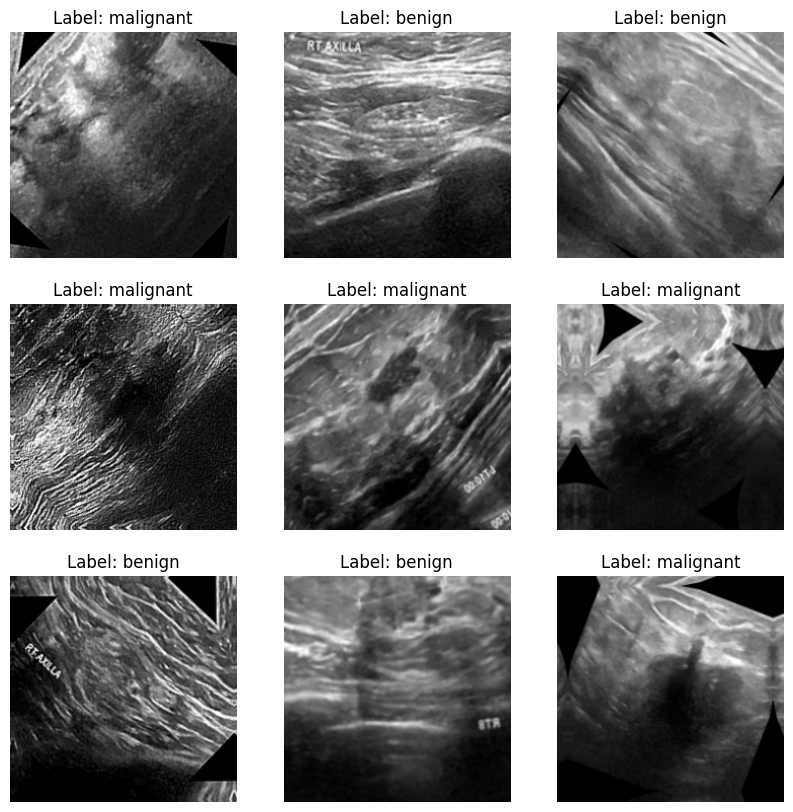

In [9]:
# Explore the first batch of preprocessed images after data augmentation
for images, labels in train_dataset.take(1):  # Iterate through the first batch of the training dataset
    plt.figure(figsize=(10, 10))  # Create a figure for plotting
    for i in range(9):  # Display the first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image
        plt.imshow(tf.squeeze(images[i]), cmap='gray')  # Display the image, squeezing to remove single channel dimension
        label_name = class_names[labels[i].numpy()]  # Get the class name corresponding to the numeric label
        plt.title(f"Label: {label_name}")  # Set the title of the subplot with the class name
        plt.axis("off")  # Turn off axis
    plt.show()  # Display the plot

**Modeling**

In [10]:
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

# Train the model with callbacks
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    batch_size=128,
                    epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 dropout_1 (Dropout)         (None, 108, 108, 128)     0         
                                                      

In [11]:
#model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 dropout_1 (Dropout)         (None, 108, 108, 128)     0         
                                                      

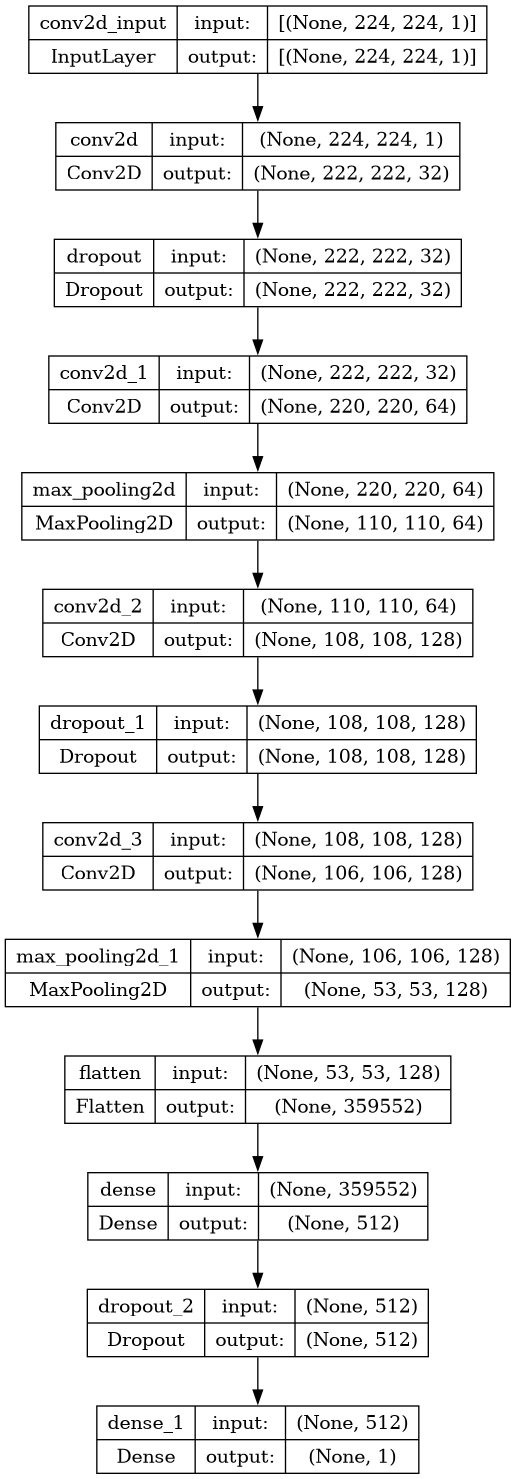

In [12]:
# Visualize model architecture
plot_model(model, to_file='model_architecture_layers.png', show_shapes=True)

In [13]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

29/29 [==============================] - 65s 2s/step - loss: 0.2576 - accuracy: 0.8767


In [14]:
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.25755324959754944
Test Accuracy: 0.8766666650772095


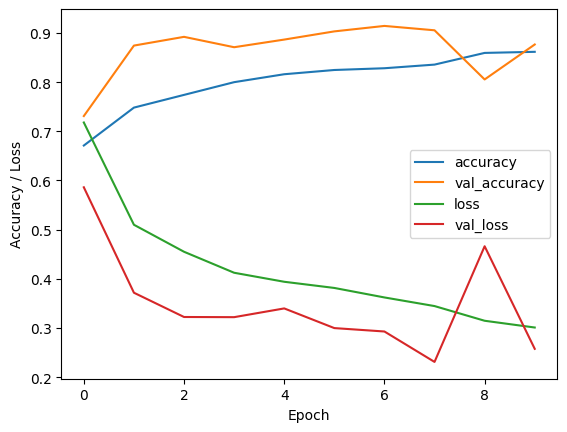

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()


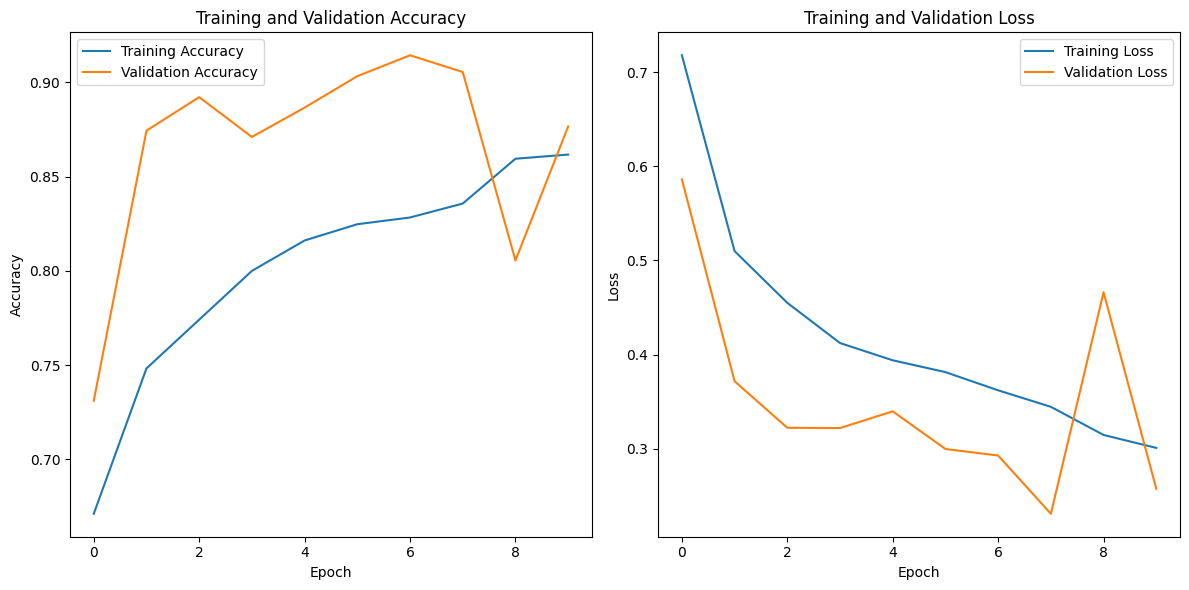

In [16]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# True labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Make predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype("int32")

# Classification Report
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(classification_rep)

29/29 [==============================] - 66s 2s/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.55      0.54      0.55       500
   malignant       0.43      0.44      0.44       400

    accuracy                           0.50       900
   macro avg       0.49      0.49      0.49       900
weighted avg       0.50      0.50      0.50       900



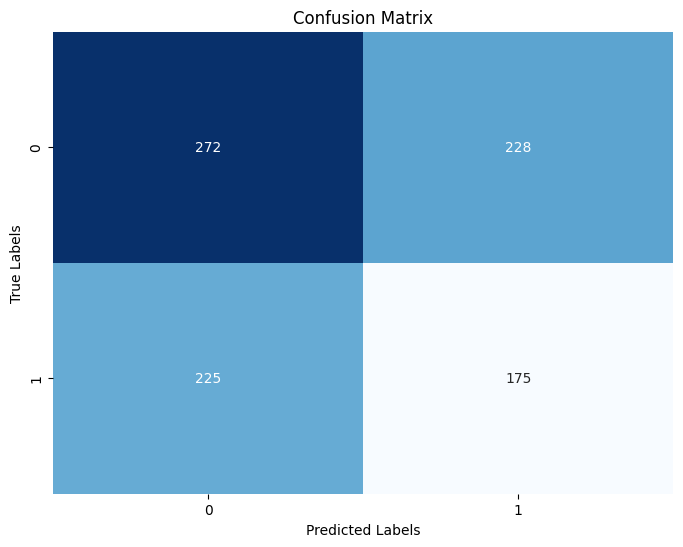

In [18]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

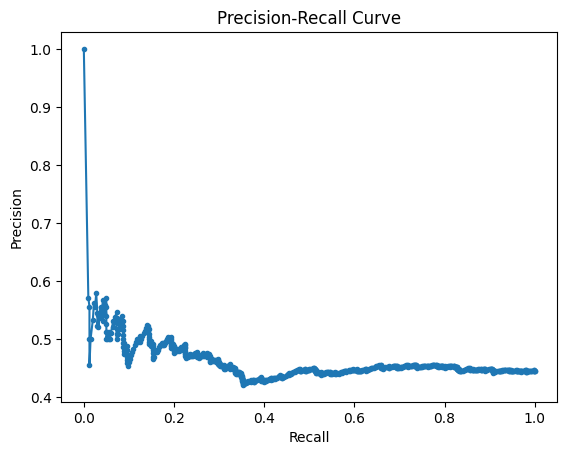

In [19]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


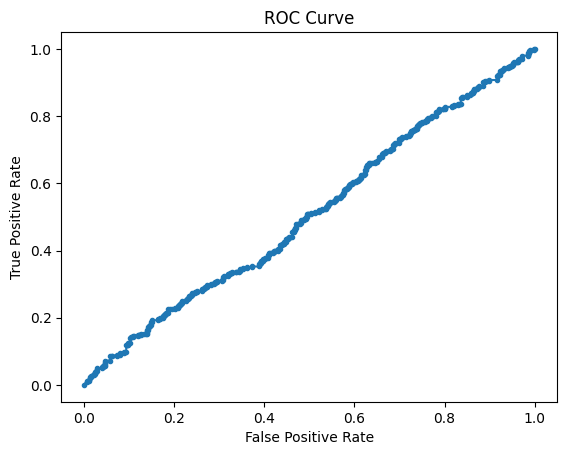

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

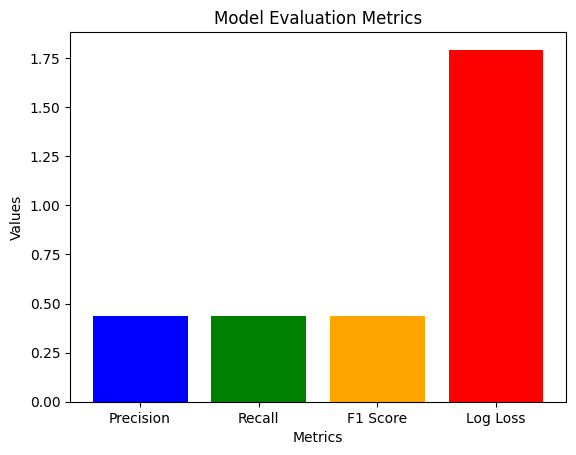

In [21]:

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
logloss = log_loss(true_labels, predictions)
# Plot metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'Log Loss']
values = [precision, recall, f1, logloss]

plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.show()

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


29/29 [==============================] - 64s 2s/step - loss: 0.2576 - accuracy: 0.8767
Test Loss: 0.25755324959754944
Test Accuracy: 0.8766666650772095


In [23]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype("int32")

# Display some predicted labels
for i in range(10):
    print("Predicted Probability:", predictions[i])
    print("Predicted Label:", predicted_labels[i])


29/29 [==============================] - 64s 2s/step
Predicted Probability: [0.02951442]
Predicted Label: [0]
Predicted Probability: [0.20743376]
Predicted Label: [0]
Predicted Probability: [0.61947197]
Predicted Label: [1]
Predicted Probability: [0.874299]
Predicted Label: [1]
Predicted Probability: [0.42852646]
Predicted Label: [0]
Predicted Probability: [0.00095612]
Predicted Label: [0]
Predicted Probability: [0.00320712]
Predicted Label: [0]
Predicted Probability: [0.96307254]
Predicted Label: [1]
Predicted Probability: [0.0855629]
Predicted Label: [0]
Predicted Probability: [0.13224086]
Predicted Label: [0]


In [24]:

# Evaluate the model using classification report
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       500
           1       0.44      0.45      0.45       400

    accuracy                           0.51       900
   macro avg       0.50      0.50      0.50       900
weighted avg       0.51      0.51      0.51       900



In [25]:
# Save the model
model.save("breast_cancer_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
